**Подключение библиотек и скриптов**

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
from collections import defaultdict
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold

# 3. Модели
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def change_bigger_feature_values_by_user(df, feature, value, change):
    if change.isdigit():
        changer = float(change)
    elif change == 'mode':
        changer = df.loc[df[feature] <= value, feature].mode()
    elif change == 'median':
        changer = df.loc[df[feature] <= value, feature].median()
    elif change == 'mean':
        changer = df.loc[df[feature] <= value, feature].mean()
    
    df.loc[df[feature] > value, feature] = changer

**Пути к директориям и файлам**

In [7]:
from pathlib import Path

TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

PREPARED_DATASET_PATH = './course_prepared.csv'
PREDICTIONS_PATH = './EVarlamov_predictions.csv'

MODELS_PATH = Path('./models/')

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'

### Загрузка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
train_df.shape

(7500, 17)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Имеются пропуски в данных**

### Обзор данных

In [11]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Признаки Maximum Open Credit, Current Loan Amount и Credit Score нуждаются в более подробном рассмотрении, т.к. медиана и среднее значение сильно отличаются**

**Обзор целевой переменной**

In [12]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [13]:
for num_colname in train_df.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(train_df[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      

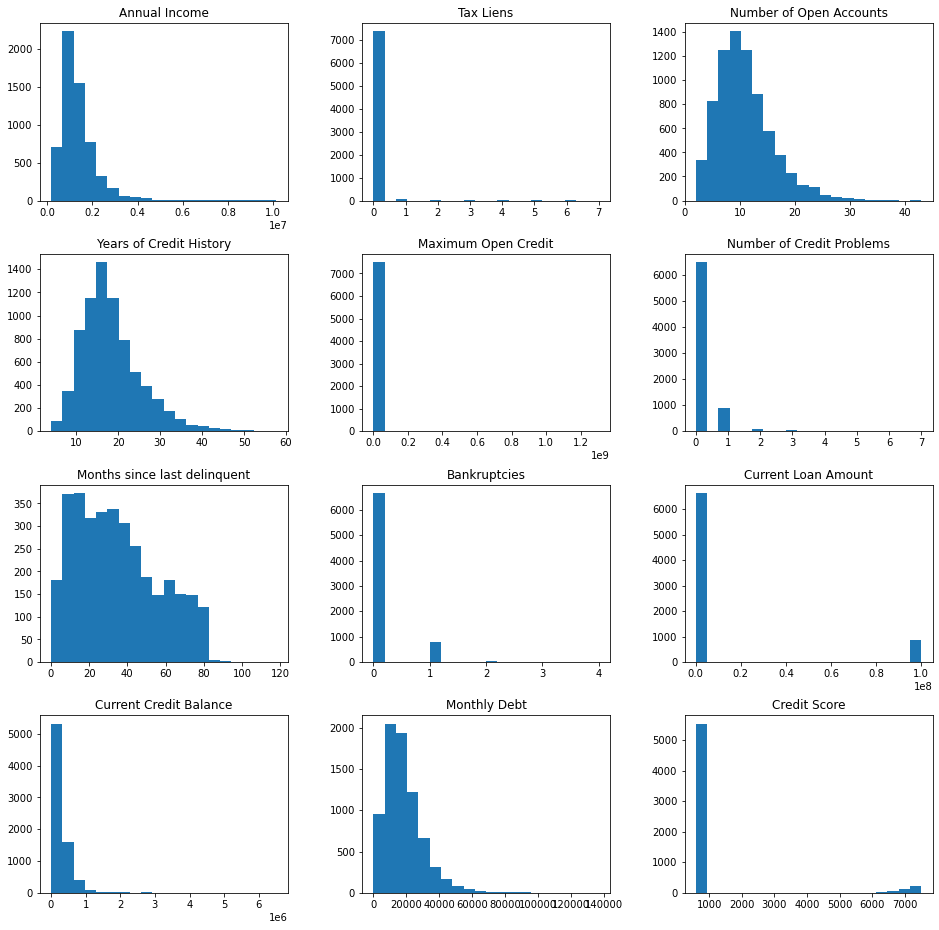

In [14]:
train_df.select_dtypes(include='float64').hist(figsize=(16, 16), bins=20, grid=False);

**У признака Current Loan Amount явно имеются пропущенные значения, вместо которых вбито число 99999999.0, нужно произвести замену. У признака Credit Score, помимо пропусков в данных, имеется большой разброс в минимальных и максимальных значениях.**

**Current Loan Amount**

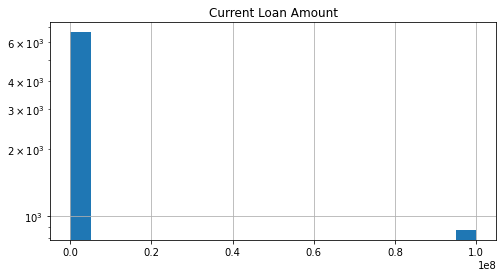

In [15]:
train_df['Current Loan Amount'].hist(figsize=(8,4), bins=20, grid=True);
plt.yscale('log')
plt.title('Current Loan Amount')
plt.show()

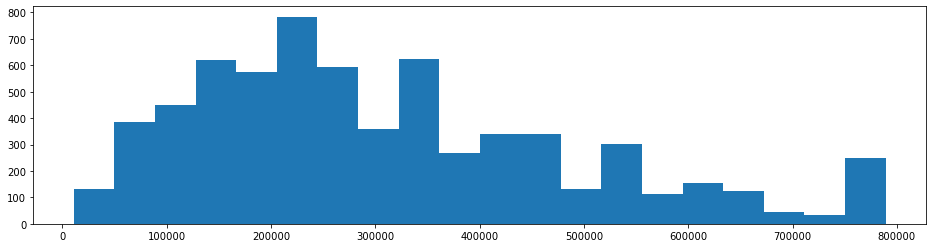

In [16]:
train_df.loc[train_df['Current Loan Amount'] < 1000000, 'Current Loan Amount'].\
    hist(figsize=(16,4), bins=20, grid=False);
#plt.yscale('log')

In [17]:
train_df['Current Loan Amount'].median()

309573.0

In [18]:
train_df['Current Loan Amount'].mode()

0    99999999.0
dtype: float64

In [19]:
test_df['Current Loan Amount'].mode()

0    99999999.0
dtype: float64

**Заменим сразу на трейне и на тесте**

In [20]:
change_bigger_feature_values_by_user(train_df, 'Current Loan Amount', 800000, '800000')
change_bigger_feature_values_by_user(test_df, 'Current Loan Amount', 800000, '800000')

**Credit Score**

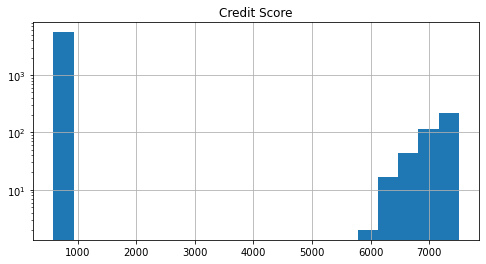

In [21]:
train_df['Credit Score'].hist(figsize=(8,4), bins=20, grid=True);
plt.yscale('log')
plt.title('Credit Score')
plt.show()

In [22]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.000000,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,365977.561067,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,232589.839954,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.000000,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309573.000000,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,519882.000000,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,800000.000000,6.506797e+06,136679.000000,7510.000000,1.000000


**Среднее значение признака Credit Score = 1151, что выше 50го (731) и 75го перцентиля (743). Возможен сдвиг на 1 порядок**

**Maximum Open Credit**

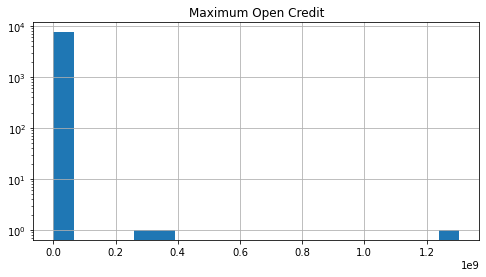

In [23]:
train_df['Maximum Open Credit'].hist(figsize=(8,4), bins=20, grid=True);
plt.yscale('log')
plt.title('Maximum Open Credit')
plt.show()

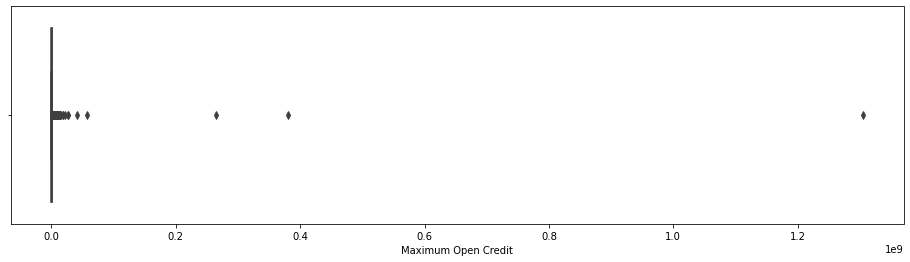

In [24]:
plt.figure(figsize=(16, 4))

sns.boxplot(train_df['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

In [25]:
train_df.nlargest(5, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,800000.0,1908550.0,5770.0,743.0,0


**У признака Maximum Open Credit имеются странные максимальные значения 8 и 9го порядков. Явные выбросы. Нужна замена на число меньшего порядка, например 99999999**

In [26]:
change_bigger_feature_values_by_user(train_df, 'Maximum Open Credit', 99999999, '99999999')

**Итог по количественным признакам: Credit Score - нужно сместить на порядок одну из групп данных; Maximum Open Credit имеет нулевые значения**
    

**Обзор номинативных признаков**

In [27]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')    

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**У признака Years in current job имеются пропуски в виде Nan.**

**Выделение целевой переменной и групп признаков**

In [28]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

*Имеется дисбаланс классов, можно вычислить разницу для будущего применения в моделях*

In [29]:
ratio = train_df['Credit Default'].value_counts()[0] / train_df['Credit Default'].value_counts()[1]

**Выделение групп признаков**

In [30]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies','Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Корреляция с базовыми признаками**

In [31]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()

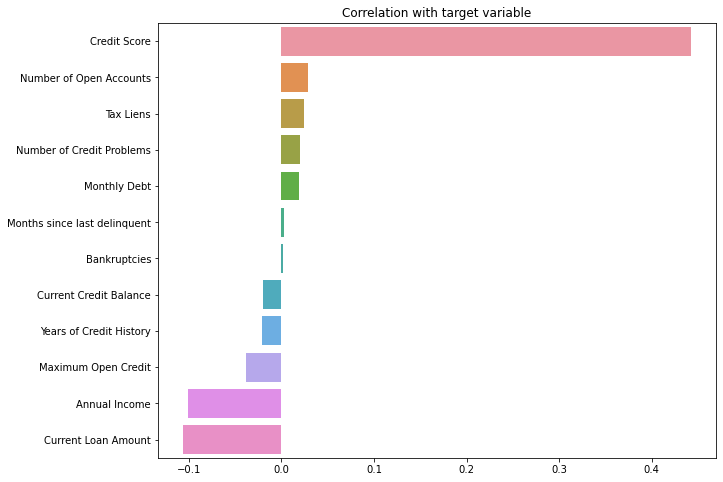

In [32]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

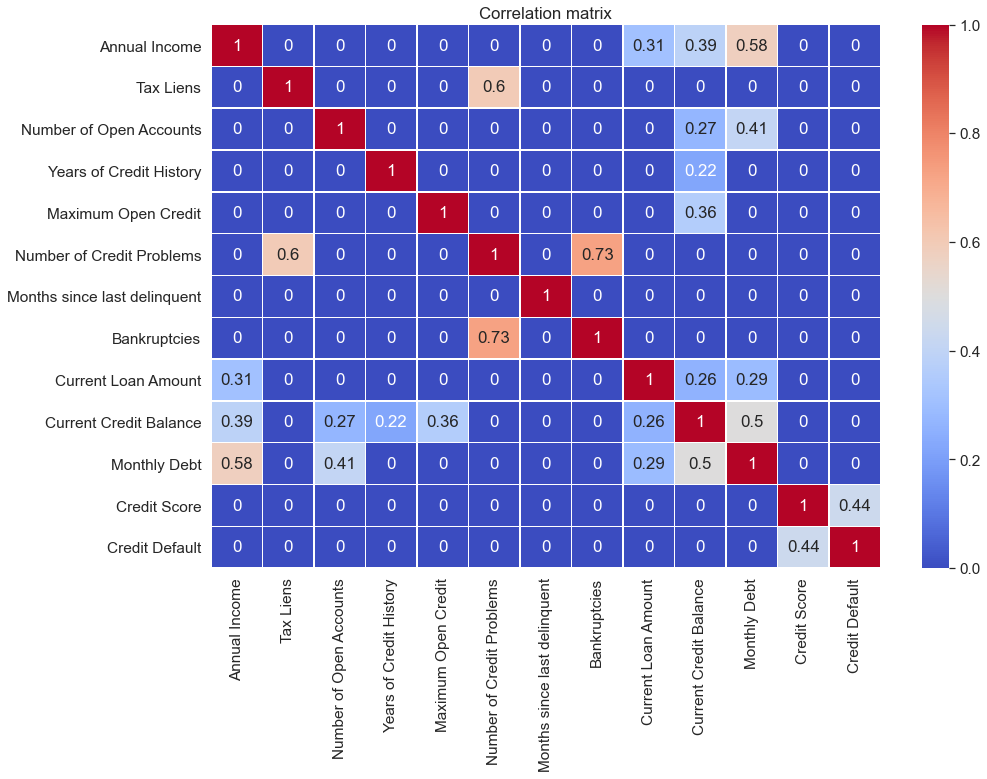

In [33]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)
corr_matrix = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Целевая переменная линейно зависима только с признаком Credit Score. Имеется отрицательная корреляция с несколькими признаками**

**Оценка признака Credit Score в разрезе целевой переменной**

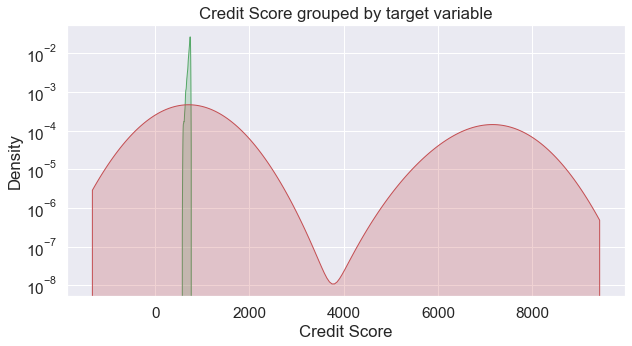

In [34]:
cscore_with_target = train_df[['Credit Score', TARGET_NAME]]
cscore = cscore_with_target['Credit Score']
cscore_target_0 = cscore[cscore_with_target[TARGET_NAME] == 0]
cscore_target_1 = cscore[cscore_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cscore_target_0, shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(cscore_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.yscale('log')
plt.show()

**Нужно привести значения Credit Score к одному порядку на train и test**

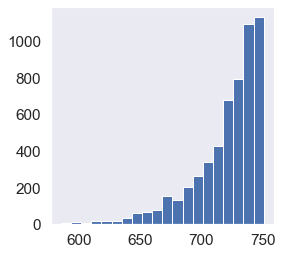

In [35]:
train_df.loc[train_df['Credit Score'] < 800, 'Credit Score'].\
    hist(figsize=(4,4), bins=20, grid=False);
#plt.yscale('log')

In [36]:
train_df.loc[train_df['Credit Score'] > 800, 'Credit Score'] = train_df['Credit Score'] / 10
test_df.loc[test_df['Credit Score'] > 800, 'Credit Score'] = test_df['Credit Score'] / 10

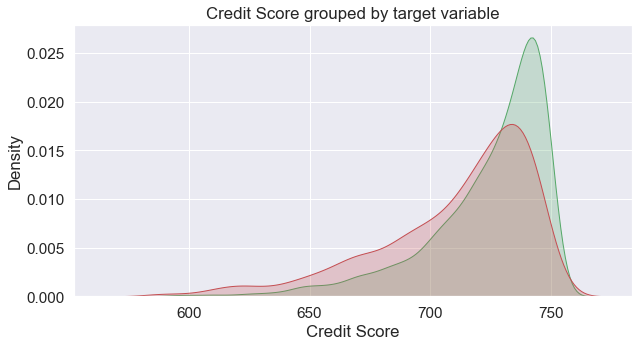

In [37]:
cscore_with_target = train_df[['Credit Score', TARGET_NAME]]
cscore = cscore_with_target['Credit Score']
cscore_target_0 = cscore[cscore_with_target[TARGET_NAME] == 0]
cscore_target_1 = cscore[cscore_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cscore_target_0, shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(cscore_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

Похоже что две группы, полученные в результате разбиения признака Credit Score по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком Credit Score и целевой переменной, возможно, существует некоторая функциональная зависимость.

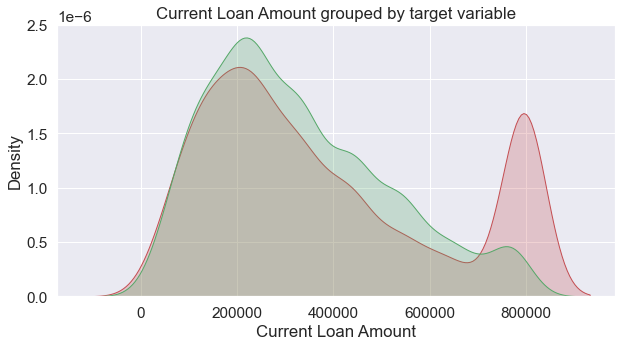

In [38]:
loan_with_target = train_df[['Current Loan Amount', TARGET_NAME]]
loan = loan_with_target['Current Loan Amount']
loan_target_0 = loan[loan_with_target[TARGET_NAME] == 0]
loan_target_1 = loan[loan_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(loan_target_0, shade=True, label='Погашен вовремя', color='r')
sns.kdeplot(loan_target_1, shade=True, label='Просрочка', color='g')
plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

Похоже что две группы, полученные в результате разбиения признака Credit Score по целевой переменной, имеют различные распределения. Между признаком Credit Score и целевой переменной, возможно, существует некоторая функциональная зависимость.

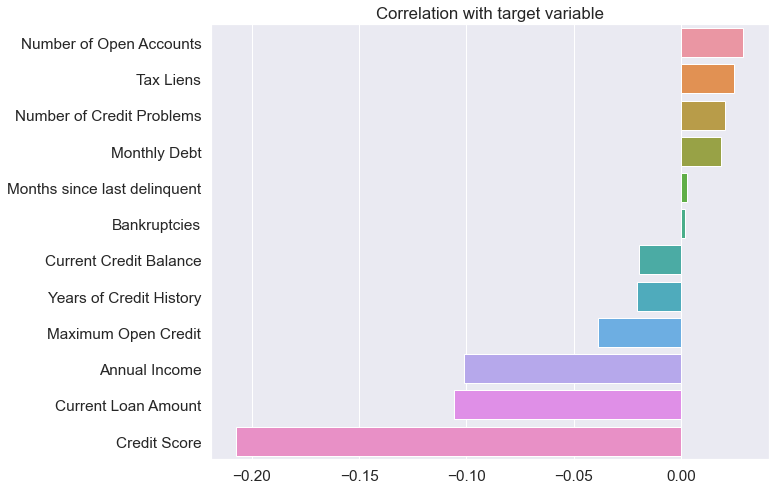

In [39]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Проверим распределения вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


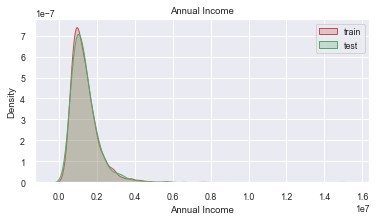

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


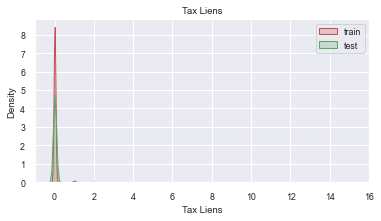

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


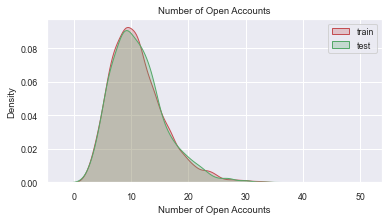

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


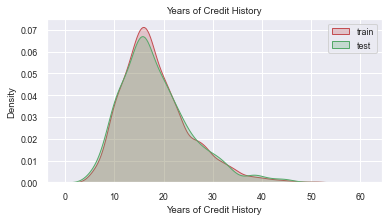

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.38322209934012874)


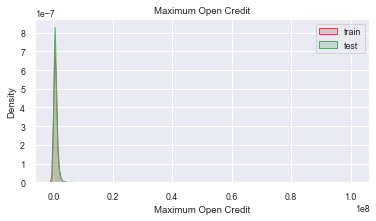

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


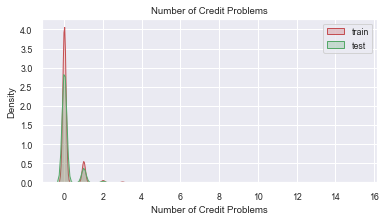

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


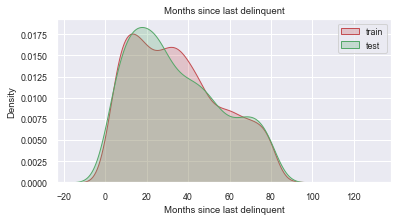

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


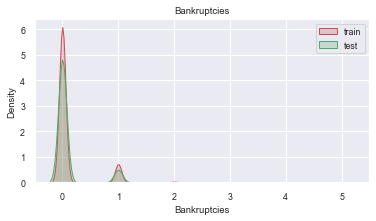

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


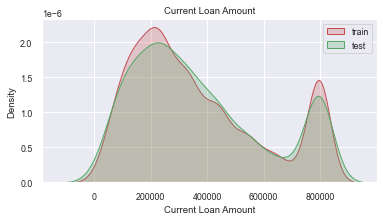

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


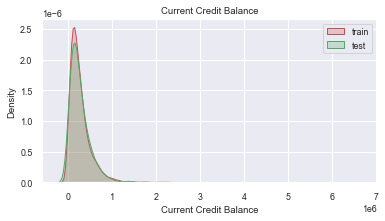

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


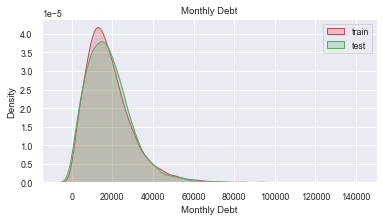

Credit Score
MannwhitneyuResult(statistic=9265042.0, pvalue=0.1895145850549937)


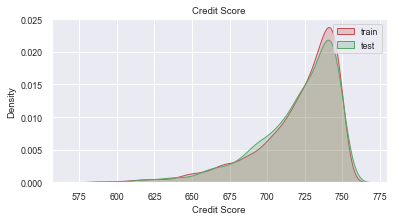

In [40]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

**Проверим распределения категориальных признаков на трейне и тесте**

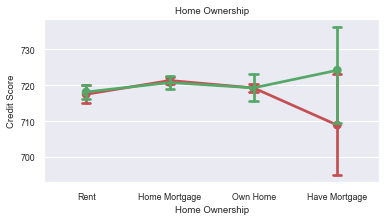

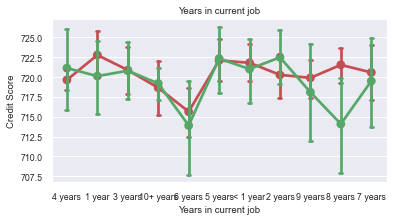

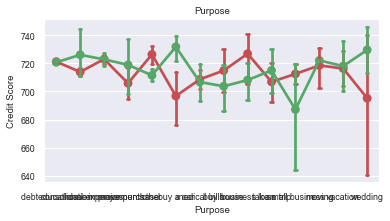

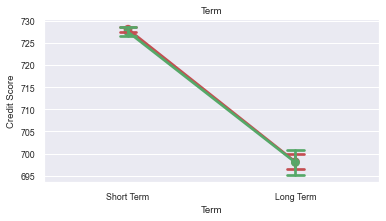

In [41]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

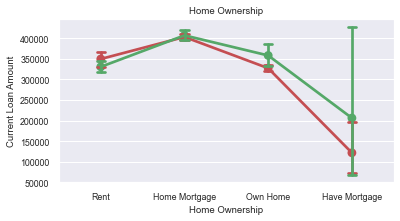

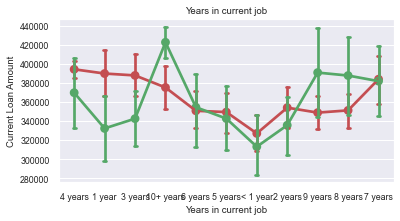

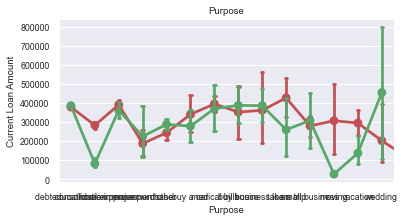

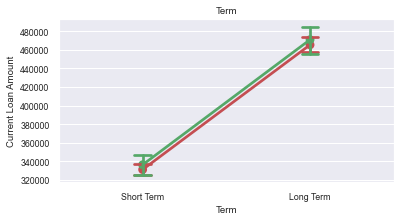

In [42]:
num_feature = 'Current Loan Amount'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

### Обработка пропусков

In [43]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [44]:
test_df.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

**Annual Income**

In [45]:
train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()
test_df.loc[test_df['Annual Income'].isnull(), 'Annual Income'] = test_df['Annual Income'].median()

**Months since last delinquent**

In [46]:
train_df.loc[train_df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
test_df.loc[test_df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

**Credit Score**

In [47]:
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = 740
test_df.loc[test_df['Credit Score'].isnull(), 'Credit Score'] = 729

**Bankruptcies**

In [48]:
train_df.loc[train_df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
test_df.loc[test_df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

**Years in current job**

In [49]:
train_df.loc[train_df['Years in current job'].isnull(), 'Years in current job'] =\
             train_df['Years in current job'].mode()[0]
test_df.loc[test_df['Years in current job'].isnull(), 'Years in current job'] =\
             test_df['Years in current job'].mode()[0]

### Построение новых признаков

*При просмотре категориальных признаков возникла идея: посчитать отношение 1 (единиц) в целевой переменной для конкретного значения этого признака к общему количеству строк датасета. Новые признаки могут оказать сильное влияние на модель. Только после добавления новых признаков нужно будет заменить категориальные признаки на dummy и бинарные.*

In [50]:
cat_with_percentage = defaultdict(list)

In [51]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [52]:
for cat_colname in test_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(test_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    896
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

In [53]:
def target_correlation_by_nominative(df, feature, feature_name):
    new_df = df.loc[df[feature] == feature_name, 'Credit Default']
    return round(len(new_df.loc[df['Credit Default'] == 1]) / len(df), 4) #len(new_df)

In [54]:
my_list = []
for cat_colname in train_df.select_dtypes(include='object').columns:
    new_l = list(set(train_df[cat_colname]))
    for i in new_l:
        print(cat_colname, "['", i, "']", target_correlation_by_nominative(train_df, cat_colname, i))
        my_list.append(target_correlation_by_nominative(train_df, cat_colname, i))
        cat_with_percentage[i] = target_correlation_by_nominative(train_df, cat_colname, i)

Home Ownership [' Own Home '] 0.0256
Home Ownership [' Have Mortgage '] 0.0003
Home Ownership [' Rent '] 0.1337
Home Ownership [' Home Mortgage '] 0.1221
Years in current job [' 4 years '] 0.0175
Years in current job [' 7 years '] 0.0148
Years in current job [' 10+ years '] 0.1041
Years in current job [' < 1 year '] 0.0212
Years in current job [' 8 years '] 0.0123
Years in current job [' 2 years '] 0.0257
Years in current job [' 1 year '] 0.0189
Years in current job [' 3 years '] 0.0227
Years in current job [' 5 years '] 0.0193
Years in current job [' 9 years '] 0.0087
Years in current job [' 6 years '] 0.0165
Purpose [' take a trip '] 0.0013
Purpose [' small business '] 0.0019
Purpose [' business loan '] 0.0073
Purpose [' medical bills '] 0.0029
Purpose [' renewable energy '] 0.0003
Purpose [' buy a car '] 0.0032
Purpose [' moving '] 0.0003
Purpose [' major purchase '] 0.0012
Purpose [' debt consolidation '] 0.2205
Purpose [' home improvements '] 0.0144
Purpose [' other '] 0.0263
Purp

**Добавляем Percentages**

In [55]:
df_cat_perc = pd.DataFrame({
    "cat_value": cat_with_percentage.keys(),
    "cat_value_percentage": cat_with_percentage.values()})  

df_cat_perc

,cat_value,cat_value_percentage
0,Own Home,0.0256
1,Have Mortgage,0.0003
2,Rent,0.1337
3,Home Mortgage,0.1221
4,4 years,0.0175
5,7 years,0.0148
6,10+ years,0.1041
7,< 1 year,0.0212
8,8 years,0.0123
9,2 years,0.0257


In [56]:
home_own_perc = pd.DataFrame({
    "Home Ownership": np.unique(train_df["Home Ownership"]),
    "Home_own_percentage": my_list[:4]}) 

purpose_perc = pd.DataFrame({
    "Purpose": np.unique(train_df["Purpose"]),
    "Purpose_percentage": my_list[15:30]})

term_perc = pd.DataFrame({
    "Term": np.unique(train_df["Term"]),
    "Term_percentage": my_list[30:]})

years_perc = pd.DataFrame({
    "Years in current job": np.unique(train_df["Years in current job"]),
    "Years_percentage": my_list[4:15]})

In [57]:
train_df = train_df.merge(home_own_perc, on='Home Ownership', how='left')
train_df = train_df.merge(purpose_perc, on='Purpose', how='left')
train_df = train_df.merge(term_perc, on='Term', how='left')
train_df = train_df.merge(years_perc, on='Years in current job', how='left')

In [58]:
test_df = test_df.merge(home_own_perc, on='Home Ownership', how='left')
test_df = test_df.merge(purpose_perc, on='Purpose', how='left')
test_df = test_df.merge(term_perc, on='Term', how='left')
test_df = test_df.merge(years_perc, on='Years in current job', how='left')

In [59]:
sum_percentages = pd.DataFrame({"Sum_percentages": 
                                train_df['Home_own_percentage'] + 
                                train_df['Purpose_percentage'] + 
                                train_df['Term_percentage']})

train_df = pd.concat([train_df, sum_percentages], axis=1)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home_own_percentage,Purpose_percentage,Term_percentage,Years_percentage,Sum_percentages
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,800000.0,47386.0,7914.0,749.0,0,0.1337,0.0029,0.1088,0.0148,0.2454
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,264968.0,394972.0,18373.0,737.0,1,0.1337,0.0029,0.1729,0.0148,0.3095
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,800000.0,308389.0,13651.0,742.0,0,0.0003,0.0029,0.1088,0.0193,0.1120
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,121396.0,95855.0,11338.0,694.0,0,0.1337,0.0029,0.1088,0.0189,0.2454
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,125840.0,93309.0,7180.0,719.0,0,0.1221,0.0029,0.1088,0.0193,0.2338


In [60]:
sum_percentages_test = pd.DataFrame({"Sum_percentages": 
                                test_df['Home_own_percentage'] + 
                                test_df['Purpose_percentage'] + 
                                test_df['Term_percentage']})

test_df = pd.concat([test_df, sum_percentages_test], axis=1)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home_own_percentage,Purpose_percentage,Term_percentage,Years_percentage,Sum_percentages
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,Short Term,162470.0,105906.0,6813.0,729.0,0.1221,0.0029,0.1088,0.0123,0.2338
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,Short Term,78298.0,46037.0,2318.0,699.0,0.1221,0.0003,0.1088,0.0175,0.2312
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,...,Short Term,200178.0,146490.0,18729.0,726.0,0.0003,0.0029,0.1088,0.0212,0.1120
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,Short Term,217382.0,213199.0,27559.0,739.0,0.0003,0.0029,0.1088,0.0148,0.1120
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,...,Long Term,777634.0,425391.0,42605.0,706.0,0.0003,0.0029,0.1729,0.0189,0.1761


**Теперь можно добавить dummy или заменить категориальные признаки на числовые значения**

**Home Ownership**

In [61]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Home Ownership'])], axis=1)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,Home_own_percentage,Purpose_percentage,Term_percentage,Years_percentage,Sum_percentages,Have Mortgage,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0.1337,0.0029,0.1088,0.0148,0.2454,0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,1,0.1337,0.0029,0.1729,0.0148,0.3095,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0.0003,0.0029,0.1088,0.0193,0.1120,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0.1337,0.0029,0.1088,0.0189,0.2454,0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0.1221,0.0029,0.1088,0.0193,0.2338,0,0,0,1


**Purpose**

In [62]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [63]:
test_df['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

Можно заменить 3 крупные группы на единицу, остальные на 0.

In [64]:
train_df.loc[(train_df['Purpose'] == 'debt consolidation') |\
             (train_df['Purpose'] == 'other') |\
             (train_df['Purpose'] == 'home improvements'), 'Purpose'] = 1
train_df.loc[train_df['Purpose'] != 1, 'Purpose'] = 0

test_df.loc[(test_df['Purpose'] == 'debt consolidation') |\
            (test_df['Purpose'] == 'other') |\
            (test_df['Purpose'] == 'home improvements'), 'Purpose'] = 1
test_df.loc[test_df['Purpose'] != 1, 'Purpose'] = 0

In [65]:
train_df['Purpose'] = train_df['Purpose'].astype('int64')
test_df['Purpose'] = test_df['Purpose'].astype('int64')

**Ниже 4 признака приводим к бинарному виду**

**Term**

In [66]:
train_df['Term'] = train_df['Term'].replace({'Short Term':0, 'Long Term':1})
test_df['Term'] = test_df['Term'].replace({'Short Term':0, 'Long Term':1})

**Bankruptcies**

In [67]:
train_df.loc[train_df['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test_df.loc[test_df['Bankruptcies'] > 0, 'Bankruptcies'] = 1

**Tax Liens**

In [68]:
train_df.loc[train_df['Tax Liens'] > 0, 'Tax Liens'] = 1
test_df.loc[test_df['Tax Liens'] > 0, 'Tax Liens'] = 1

**Number of Credit Problems**

In [69]:
train_df.loc[train_df['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test_df.loc[test_df['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1

**Years in current job**

In [70]:
train_df['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [71]:
train_df['Years in current job'] =\
train_df['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5,\
                                          '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
test_df['Years in current job'] =\
test_df['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5,\
                                         '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})

### Обучение модели

**Отбор признаков**

In [72]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job              int64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int64
Term                              int64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Home_own_percentage             float64
Purpose_percentage              float64
Term_percentage                 float64
Years_percentage                float64
Sum_percentages                 float64
Have Mortgage                     uint8
Home Mortgage                     uint8
Own Home                          uint8


In [73]:
train_df.select_dtypes(exclude='object').columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home_own_percentage',
       'Purpose_percentage', 'Term_percentage', 'Years_percentage',
       'Sum_percentages', 'Have Mortgage', 'Home Mortgage', 'Own Home',
       'Rent'],
      dtype='object')

In [74]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home_own_percentage',
       'Purpose_percentage', 'Term_percentage', 'Years_percentage',
       'Sum_percentages', 'Have Mortgage', 'Home Mortgage', 'Own Home',
       'Rent']
CAT_FEATURE_NAMES = ['Home Ownership']
NEW_FEATURE_NAMES = ['Home_own_percentage', 'Purpose_percentage', 'Term_percentage', 'Sum_percentages']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES

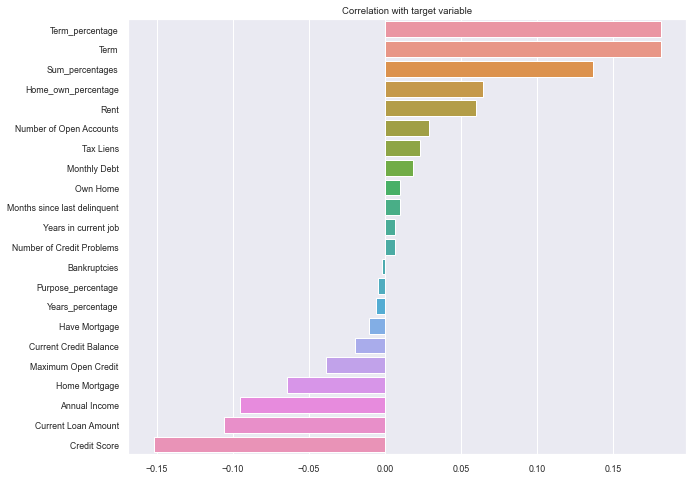

In [75]:
corr_with_target = train_df[SELECTED_FEATURE_NAMES + [TARGET_NAME]].\
corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Разбиение на train и test**

In [76]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.33,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718209
1    0.281791
Name: Credit Default, dtype: float64

0    0.718384
1    0.281616
Name: Credit Default, dtype: float64

### CatBoost

#### **Финальная модель с лучшими параметрами max_depth = 3 и iterations=33**

In [78]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, 
                                     n_estimators = 33, 
                                     max_depth=3, 
                                     class_weights = [1, ratio]
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      3609
           1       0.46      0.78      0.58      1416

    accuracy                           0.68      5025
   macro avg       0.67      0.71      0.66      5025
weighted avg       0.76      0.68      0.69      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      1778
           1       0.39      0.68      0.49       697

    accuracy                           0.61      2475
   macro avg       0.61      0.63      0.59      2475
weighted avg       0.70      0.61      0.63      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1040  738
1                226  471
Wall time: 185 ms


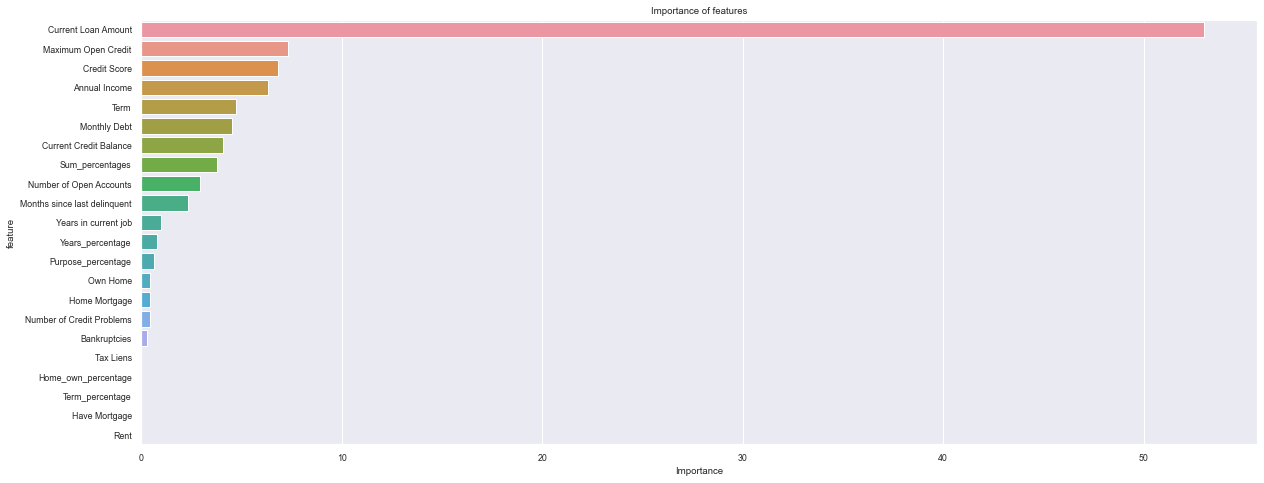

In [79]:
important_features_top = show_feature_importances(X_train.columns,
                                                  model_catb.feature_importances_, get_top=19)

**Обучение на всем наборе train**

In [80]:
X_train = train_df[SELECTED_FEATURE_NAMES]
y_train = train_df['Credit Default']
X_test = test_df[SELECTED_FEATURE_NAMES]

In [81]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, 
                                     n_estimators = 33, 
                                     max_depth=3, 
                                     class_weights = [1, ratio]
                                    )

In [82]:
model_catb.fit(X_train, y_train)
y_test_preds = model_catb.predict(X_test)

In [85]:
y_test_preds

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [86]:
submit = pd.DataFrame()
submit['Id'] = test_df.index
submit['Credit Default'] = pd.Series(y_test_preds)

In [87]:
submit.to_csv('EVarlamov_fin_submit.csv', index=False)
submit

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0
